# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! In this tutorial, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial or use "File -> Open in playground mode" to play with it yourself.


# Install detectron2

In [0]:
# install dependencies:
# (use +cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

In [0]:
# install detectron2:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


def readCsv(csvfname):
    # read csv to list of lists
    with open(csvfname, 'r') as csvf:
        reader = csv.reader(csvf)
        csvlines = list(reader)
    return csvlines

# Run a pre-trained detectron2 model

We first download a random image from the COCO dataset:

In [0]:
'''
!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
outputs["instances"].pred_boxes
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
'''

'\n!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg\nim = cv2.imread("./input.jpg")\ncv2_imshow(im)\ncfg = get_cfg()\n# add project-specific config (e.g., TensorMask) here if you\'re not running a model in detectron2\'s core library\ncfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))\ncfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model\n# Find a model from detectron2\'s model zoo. You can use the https://dl.fbaipublicfiles... url as well\ncfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")\npredictor = DefaultPredictor(cfg)\noutputs = predictor(im)\n# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification\noutputs["instances"].pred_classes\noutputs["instances"].pred_boxes\n# We can use `Visualizer` to draw the predictions on the image.\nv = Visualizer(im[:, :, ::-1], Meta

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp -a /content/gdrive/My*Drive/group3_challenge/881-preprocess/data_pics/. /content/

In [5]:
import os
os.getcwd()

'/content'

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [10]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import csv

#csvlines = readCsv('IndexNodules.csv')
#print(len(csvlines))

def get_balloon_dicts():
    #json_file = os.path.join(img_dir, "via_region_data.json")
    #with open(json_file) as f:
    #    imgs_anns = json.load(f)

    csvlines = readCsv('/content/gdrive/My Drive/group3_challenge/881-preprocess/IndexNodules.csv')

    #path = "/content/gdrive/My Drive/group3_challenge/881-preprocess/data_pics/"
    #oldcwd = os.getcwd()
    #os.chdir(path)

    dataset_dicts = []
    #for idx, v in enumerate(imgs_anns.values()):
    #list_ind = ['1','1','2','2','2','2','2','2','2','2','3','3','3','3','3']
    #num_ind = ['0','1','0','1','2','3','4','5','6','7','0','1','2','3','4']
    for i in range((len(csvlines))-1):
        nodules = csvlines[i+1]
        patient_id = nodules[0]
        scan_id = nodules[1]
        record = {}
      
        filename = 'LNDb-{:04}'.format(int(patient_id)) + '_' + str(scan_id) +'.jpg'
        height, width = cv2.imread(filename).shape[:2]
        #print(path+filename)
        record["file_name"] = filename
        record["image_id"] = (i+10)
        record["height"] = height
        record["width"] = width
        
        #annos = v["regions"]
        objs = []
        #for _, anno in annos.items():
        #    assert not anno["region_attributes"]
        #    anno = anno["shape_attributes"]
        #    px = anno["all_points_x"]
        #    py = anno["all_points_y"]
        #   poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        #   poly = [p for x in poly for p in x]
        
        x_point = int(nodules[2])
        y_point = int(nodules[3])
        #make the diameter 6 mm 

        obj = {
            "bbox": [x_point-10, y_point-10, x_point+10, y_point+10 ],
            "bbox_mode": BoxMode.XYXY_ABS,
            #"segmentation": [poly],
            "category_id": 0,
            "iscrowd": 0
        }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    #os.chdir(oldcwd)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts())
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["nodule"])
balloon_metadata = MetadataCatalog.get("balloon_train")


AssertionError: ignored

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



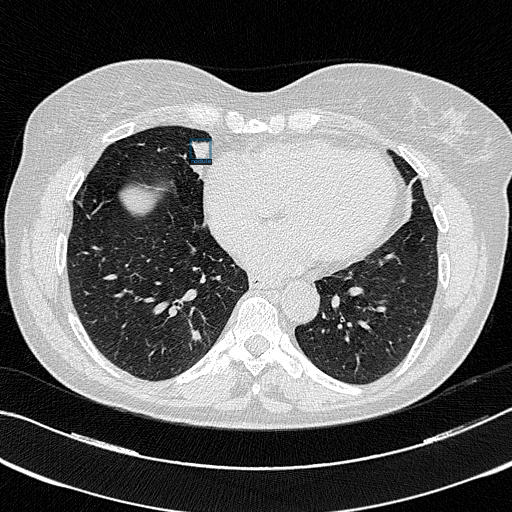

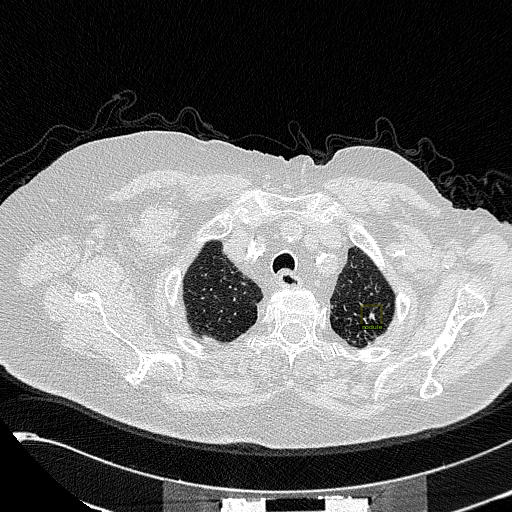

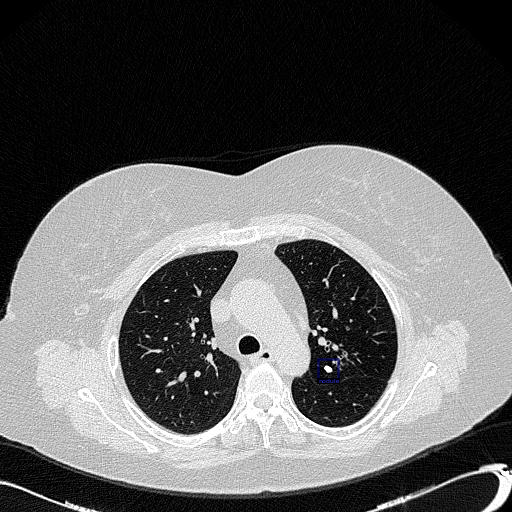

In [11]:
dataset_dicts = get_balloon_dicts()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    #print(type(img))
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.008 # pick a good LR
cfg.SOLVER.MAX_ITER = 800    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/10 22:10:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_51d356.pkl: 663MB [00:10, 63.5MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


[02/10 22:11:15 d2.engine.train_loop]: Starting training from iteration 0
[02/10 22:11:27 d2.utils.events]: eta: 0:07:58  iter: 19  total_loss: 0.603  loss_cls: 0.403  loss_box_reg: 0.008  loss_rpn_cls: 0.165  loss_rpn_loc: 0.003  time: 0.6165  data_time: 0.0145  lr: 0.000160  max_mem: 3911M
[02/10 22:11:39 d2.utils.events]: eta: 0:07:40  iter: 39  total_loss: 0.215  loss_cls: 0.074  loss_box_reg: 0.000  loss_rpn_cls: 0.083  loss_rpn_loc: 0.004  time: 0.6047  data_time: 0.0073  lr: 0.000320  max_mem: 3911M
[02/10 22:11:51 d2.utils.events]: eta: 0:07:30  iter: 59  total_loss: 0.134  loss_cls: 0.060  loss_box_reg: 0.017  loss_rpn_cls: 0.036  loss_rpn_loc: 0.004  time: 0.6132  data_time: 0.0051  lr: 0.000480  max_mem: 3914M
[02/10 22:12:03 d2.utils.events]: eta: 0:07:08  iter: 79  total_loss: 0.118  loss_cls: 0.066  loss_box_reg: 0.025  loss_rpn_cls: 0.018  loss_rpn_loc: 0.005  time: 0.6042  data_time: 0.0069  lr: 0.000639  max_mem: 3914M
[02/10 22:12:14 d2.utils.events]: eta: 0:06:51  it

In [13]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95  # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

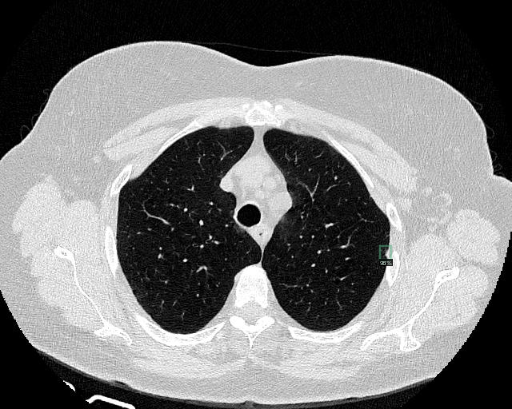

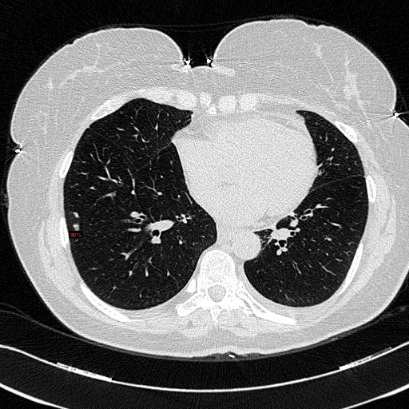

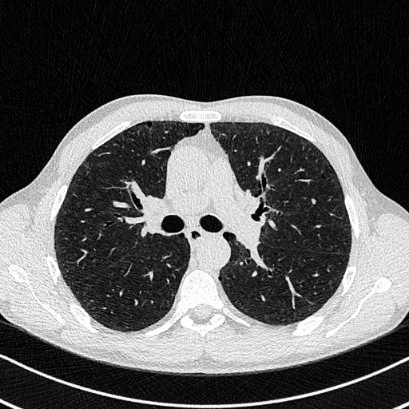

In [23]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts()
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    #print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [24]:
# WRITE THE INSTANCES TO FILE 
#create a list of testing files 

with open('predicted_nodules_95_R50_DC5_1x.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Filename', 'Center Coordinate X', 'Center Coordinate Y','Score'])

    csvlines = readCsv('/content/gdrive/My Drive/group3_challenge/881-preprocess/IndexNodules.csv')

    for i in range((len(csvlines))-1):
      nodules = csvlines[i+1]
      patient_id = nodules[0]
      scan_id = nodules[1]
      filename = 'LNDb-{:04}'.format(int(patient_id)) + '_' + str(scan_id) +'.jpg'
      print(filename)
      im = cv2.imread(filename)
      outputs = predictor(im)

      instance = outputs["instances"]
      fields = instance.get_fields()
      confidence = fields['scores']
      coord = fields['pred_boxes'].get_centers()

      #print(filename)
      for k in range(len(instance)):
        center = coord[k].data.tolist()
        score = confidence[k].item()
      
        writer.writerow([filename, center[0], center[1], score])



LNDb-0001_0.jpg
LNDb-0001_1.jpg
LNDb-0002_0.jpg
LNDb-0002_1.jpg
LNDb-0002_2.jpg
LNDb-0002_3.jpg
LNDb-0002_4.jpg
LNDb-0002_5.jpg
LNDb-0002_6.jpg
LNDb-0002_7.jpg
LNDb-0003_0.jpg
LNDb-0003_1.jpg
LNDb-0003_2.jpg
LNDb-0003_3.jpg
LNDb-0003_4.jpg
LNDb-0004_0.jpg
LNDb-0004_1.jpg
LNDb-0004_2.jpg
LNDb-0005_0.jpg
LNDb-0005_1.jpg
LNDb-0007_0.jpg
LNDb-0007_1.jpg
LNDb-0008_0.jpg
LNDb-0008_1.jpg
LNDb-0008_2.jpg
LNDb-0008_3.jpg
LNDb-0008_4.jpg
LNDb-0010_0.jpg
LNDb-0010_1.jpg
LNDb-0010_2.jpg
LNDb-0010_3.jpg
LNDb-0010_4.jpg
LNDb-0010_5.jpg
LNDb-0010_6.jpg
LNDb-0010_7.jpg
LNDb-0010_8.jpg
LNDb-0010_9.jpg
LNDb-0010_10.jpg
LNDb-0010_11.jpg
LNDb-0010_12.jpg
LNDb-0010_13.jpg
LNDb-0011_0.jpg
LNDb-0011_1.jpg
LNDb-0011_2.jpg
LNDb-0011_3.jpg
LNDb-0011_4.jpg
LNDb-0011_5.jpg
LNDb-0011_6.jpg
LNDb-0013_0.jpg
LNDb-0013_1.jpg
LNDb-0013_2.jpg
LNDb-0013_3.jpg
LNDb-0013_4.jpg
LNDb-0013_5.jpg
LNDb-0013_6.jpg
LNDb-0013_7.jpg
LNDb-0013_8.jpg
LNDb-0015_0.jpg
LNDb-0015_1.jpg
LNDb-0015_2.jpg
LNDb-0015_3.jpg
LNDb-0015_4.jpg
LNDb

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

# Other types of builtin models

In [0]:
'''
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test




# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
'''

In [0]:
# Download the results
from google.colab import files
files.download('video-output.mkv')